<a href="https://colab.research.google.com/github/LxMera/Convolutional-Neural-Network-for-the-classification-of-independent-components-of-rs-fMRI/blob/master/CNN_in_3D_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#function ClickConnect(){ console.log("Working2"); document.querySelector("colab-toolbar-button#connect").click() }setInterval(ClickConnect,10000)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install  nilearn

In [ ]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from nilearn import image
import cv2
import scipy.io as sio
import pandas as pd

In [ ]:
mats=np.array(glob.glob('/content/drive/My Drive/rsfMRI/Comprimidos/*.mat'))
print(np.shape(mats))

(290,)


(75, 57, 73, 57)
(200, 75)
(1, 75)


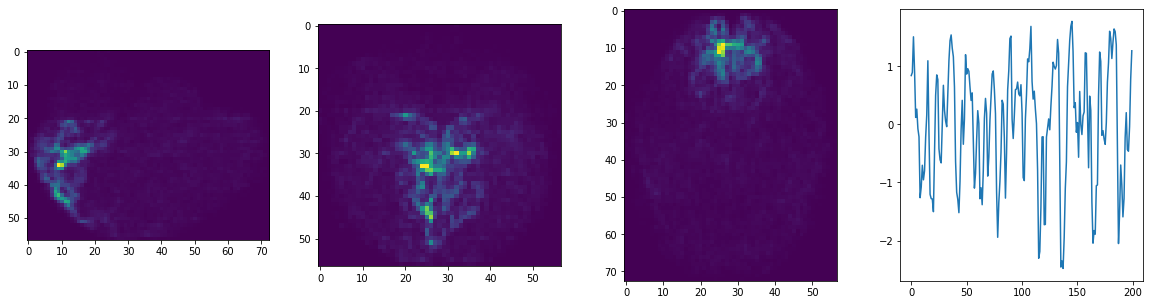

In [ ]:
sub=sio.loadmat(mats[280])
maps=sub['maps']
labe=sub['labels']
time=sub['times']

comp=15
plt.figure(figsize=(20,5))
plt.subplot(1,4,1)
plt.imshow(np.var(maps[comp,:,:,:], axis=2))
plt.subplot(1,4,2)
plt.imshow(np.var(maps[comp,:,:,:], axis=1))
plt.subplot(1,4,3)
plt.imshow(np.var(maps[comp,:,:,:], axis=0))
plt.subplot(1,4,4)
plt.plot(time[:,comp])

print(np.shape(maps))
print(np.shape(time))
print(np.shape(labe))

In [ ]:
from tensorflow.python.framework import ops
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dropout, Lambda
from tensorflow.keras.layers import Conv3D
from tensorflow.keras.layers import MaxPooling3D
from tensorflow.keras.layers import Flatten, Dense, Activation
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf

In [ ]:
def get_LeNet2(mps, nb_classes=2, maxR=0.4):
    ops.reset_default_graph()
    tf.keras.backend.clear_session()    
    
    inputs = Input(np.shape(mps)[1:]+(1,))
    s = Lambda(lambda x: x / 255) (inputs)

    c1 = Conv3D(20, (5, 5, 5), activation='relu', kernel_initializer='he_normal', padding='same') (s)
    c1 = MaxPooling3D((2, 2, 2)) (c1)
    c1 = Dropout(maxR)(c1) 

    c2 = Conv3D(50, (5, 5, 5), activation='relu', kernel_initializer='he_normal', padding='same') (c1)
    c2 = MaxPooling3D((2, 2, 2)) (c2)
    c2 = Dropout(maxR)(c2) 

    c6 = Flatten()(c2)

    c6 = Dense(500, activation='relu')(c6)
    c6 = Dropout(maxR)(c6) 
       
    outputs = Dense(nb_classes, activation='softmax')(c6)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        
    return model

In [ ]:
modelo=get_LeNet2(maps)
modelo.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 57, 73, 57, 1)]   0         
_________________________________________________________________
lambda (Lambda)              (None, 57, 73, 57, 1)     0         
_________________________________________________________________
conv3d (Conv3D)              (None, 57, 73, 57, 20)    2520      
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 28, 36, 28, 20)    0         
_________________________________________________________________
dropout (Dropout)            (None, 28, 36, 28, 20)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 28, 36, 28, 50)    125050    
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 14, 18, 14, 50)   

In [ ]:
DirP='/content/drive/My Drive/rsfMRI'
Folders=['/HCP_hp2000', '/Standard', '/WhII_MB6', '/WhII_Standard']

In [ ]:
np.shape(mats)

(290,)

In [ ]:
mastt=[mats[:100], mats[100:206], mats[206:245], mats[245:] ]

In [ ]:
dat=np.array(['HCP_hp2000', 'Standard', 'WhII_MB6', 'WhII_Standard'])

In [ ]:
for mat2 in enumerate(mastt):
  nome='/Neuro-'+dat[mat2[0]]+'-3D-z1.h5'
  matx=mat2[1]
  print(nome)

  df=pd.DataFrame(columns=('group', 'time', 'n_ics', 'accuracy'))

  del modelo
  modelo=get_LeNet2(maps)
  earlystopper = EarlyStopping(patience=5, verbose=1)
  checkpointer = ModelCheckpoint(DirP+nome, verbose=1, save_best_only=True)

  indx=np.random.choice(len(matx),len(matx), replace=False)
  sio.savemat(DirP+nome[:-3]+'.mat', {'indices': indx})

  train=matx[indx][:int(0.8*len(matx))]

  overall=[]
  for sub in train:
    print(sub)
    sub=sio.loadmat(sub)
    x_train=sub['maps']
    y_train=np.array(sub['labels'])[0]

    try:
      modelo.load_weights(DirP+nome)
    except:
      print('New model')

    results = modelo.fit(x_train, y_train, validation_split=0.1, batch_size=16, epochs=50, callbacks=[earlystopper, checkpointer], verbose=0)

  indices=sio.loadmat(DirP+nome[:-3]+'.mat')
  ix=indices['indices']
  test=matx[ix[0]][int(0.8*len(matx)):]

  del modelo
  modelo=get_LeNet2(maps)
  modelo.summary()
  modelo.load_weights(DirP+nome)

  for sub0 in test:
    nm=sub0[43:sub0.rfind('-')]
    #print(nm)
    sub=sio.loadmat(sub0)
    x_test=sub['maps']
    y_test=np.array(sub['labels'])[0]

    y_hat=modelo.predict(x_test)
    y_bin=y_hat.argmax(axis=1)

    acc=np.mean(y_bin==y_test)

    ics,_,_,_=np.shape(x_test)
    tim,_=np.shape(sub['times'])
    #print('Accuracy', acc)
    df=df.append({'group': nm, 'time': tim,'n_ics': ics,'accuracy': acc}, ignore_index=True)
  
  df.to_csv(DirP+nome[:-3]+'.csv')

In [ ]:
csvs=glob.glob('/content/drive/My Drive/rsfMRI/*HCP*.csv')
print(csvs)
for ix in csvs:
  #ix=csvs[0]
  acc=pd.read_csv(ix)
  print(np.mean(acc['accuracy']))

['/content/drive/My Drive/rsfMRI/Neuro-HCP_hp2000-3D-y0.csv', '/content/drive/My Drive/rsfMRI/Neuro-HCP_hp2000-3D-y1.csv', '/content/drive/My Drive/rsfMRI/Neuro-HCP_hp2000-3D-z1.csv', '/content/drive/My Drive/rsfMRI/Neuro-HCP_hp2000-3D-z0.csv']
0.9741345947611046
0.9763691591936763
0.9844019977494041
0.9787169240961067


In [ ]:
csvs=glob.glob('/content/drive/My Drive/rsfMRI/*MB6*.csv')
print(csvs)
for ix in csvs:
  #ix=csvs[0]
  acc=pd.read_csv(ix)
  print(np.mean(acc['accuracy']))

['/content/drive/My Drive/rsfMRI/Neuro-WhII_MB6-3D-y0.csv', '/content/drive/My Drive/rsfMRI/Neuro-WhII_MB6-3D-y1.csv', '/content/drive/My Drive/rsfMRI/Neuro-WhII_MB6-3D-z1.csv', '/content/drive/My Drive/rsfMRI/Neuro-WhII_MB6-3D-z0.csv']
0.8741304095901815
0.9285746035258514
0.9627252423444698
0.8936173744308049


In [ ]:
csvs=glob.glob('/content/drive/My Drive/rsfMRI/*WhII_M*.csv')
print(csvs)
for ix in csvs:
  #ix=csvs[0]
  acc=pd.read_csv(ix)
  print(np.mean(acc['accuracy']))

['/content/drive/My Drive/rsfMRI/Neuro-WhII_MB6-3D-y0.csv', '/content/drive/My Drive/rsfMRI/Neuro-WhII_MB6-3D-y1.csv', '/content/drive/My Drive/rsfMRI/Neuro-WhII_MB6-3D-z1.csv', '/content/drive/My Drive/rsfMRI/Neuro-WhII_MB6-3D-z0.csv']
0.8741304095901815
0.9285746035258514
0.9627252423444698
0.8936173744308049


In [ ]:
csvs=glob.glob('/content/drive/My Drive/rsfMRI/*o-Standard*.csv')
print(csvs)
for ix in csvs:
  #ix=csvs[0]
  acc=pd.read_csv(ix)
  print(np.mean(acc['accuracy']))

['/content/drive/My Drive/rsfMRI/Neuro-Standard-3D-y0.csv', '/content/drive/My Drive/rsfMRI/Neuro-Standard-3D-y1.csv', '/content/drive/My Drive/rsfMRI/Neuro-Standard-3D-z1.csv', '/content/drive/My Drive/rsfMRI/Neuro-Standard-3D-z0.csv']
0.8589034797006202
0.7392851354239454
0.7193487997025149
0.7846778130114369


In [ ]:
names=['model 1', 'model 2', 'model 3', 'model 4', 'model 5', 'model 6', 'model 7', 'model 8', 'model 9', 'model 10', 'model 3D']

In [ ]:
Acc=[0.984703,
0.987325,
0.988418,
0.988889,
0.994444,
0.989729,
0.987107,
0.99104,
0.991667,
0.992133,
0.984401998]

In [ ]:
trainp=np.array([261014,
4130050,
2084162,
1125826,
955362,
6328072,
725302,
5796898,
2540546,
17596308,
88329072])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  

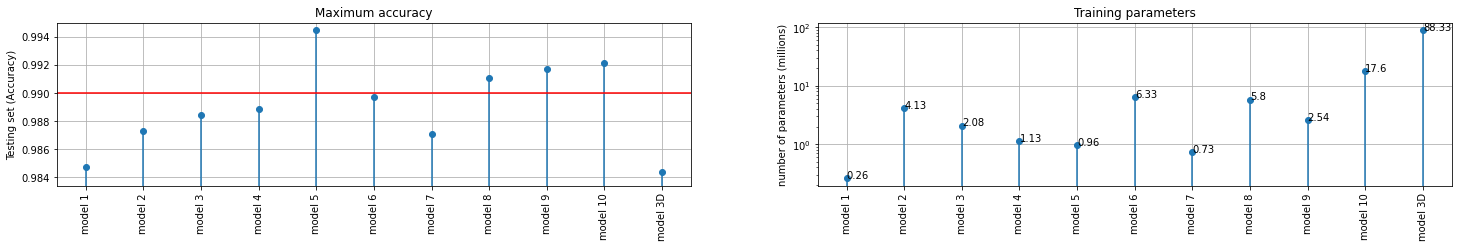

In [ ]:
plt.figure(figsize=(25,3))
plt.subplot(1,2,1)
plt.stem(np.arange(11), Acc)
plt.ylim((np.min(Acc)-0.001, 0.995))
plt.title('Maximum accuracy')
plt.ylabel('Testing set (Accuracy)')
plt.axhline(y=0.99, color='r', linestyle='-')
plt.xticks(np.arange(11), labels=names, rotation='vertical')
plt.grid()

plt.subplot(1,2,2)
#plt.axhline(y=1, color='r', linestyle='-')
plt.stem(np.arange(11), trainp/1000000)
plt.yscale('log')
plt.ylim((0, 120))
for i, txt in enumerate(trainp):
    plt.annotate(str(round(txt/1000000,2)), (np.arange(11)[i],txt/1000000))
plt.title('Training parameters')
plt.ylabel('number of parameters (millions)')

plt.xticks(np.arange(11), labels=names, rotation='vertical')
plt.grid()
plt.savefig('resultados.svg')